Iterative Imputation and MissForest 

Iterative method with different regressors for missing data imputation
- Sklearn - Iterative Imputation for Tables. https://scikit-learn.org/stable/modules/impute.html#iterative-imputer
- MissForest - https://academic.oup.com/bioinformatics/article/28/1/112/219101


## (1) Initial Setup

In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
import random
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer


### This part is for real data 

In [47]:
# Mount google drive so that any data could be accessed in this folder
# Read the data,it is important to put the "Research" directory in ones own google drive
X = np.load("/Users/jiaweizhang/research/data/X.npy")
Y = np.load("/Users/jiaweizhang/research/data/Y.npy")
Z = np.load("/Users/jiaweizhang/research/data/Z.npy")
U = np.load("/Users/jiaweizhang/research/data/U.npy")
M = np.load("/Users/jiaweizhang/research/data/M.npy")

display(pd.DataFrame(X))
display(pd.DataFrame(Y))
display(pd.DataFrame(Z))
display(pd.DataFrame(U))
display(pd.DataFrame(M))


,0,1,2,3,4
0,0.766472,-1.644463,1.135335,1.647609,0.0
1,1.228147,-0.133635,-0.159909,0.206834,1.0
2,1.526981,1.568491,0.769310,0.693670,0.0
3,0.477432,0.327402,0.300267,-0.691641,0.0
4,1.607284,-1.126374,0.615059,0.591469,1.0
...,...,...,...,...,...
19995,0.757626,-0.174572,-1.267520,0.876582,0.0
19996,-0.137899,-0.914321,-0.869284,0.295851,1.0
19997,1.737828,1.498230,0.018937,0.894567,0.0
19998,0.329276,-1.028964,0.561963,0.876246,1.0


,0,1,2
0,36.975790,23.551939,40.542855
1,7.427683,20.491803,41.315736
2,27.721509,65.341903,304.874363
3,9.646436,4.172816,3.265358
4,35.500065,34.804845,84.133658
...,...,...,...
19995,2.169075,2.442815,-0.196697
19996,-1.731654,-2.343015,-0.000662
19997,25.559103,60.395742,252.374515
19998,7.545427,14.749494,23.554173


,0
0,1.0
1,0.0
2,0.0
3,1.0
4,1.0
...,...
19995,0.0
19996,0.0
19997,0.0
19998,0.0


,0,1
0,0.691327,1.0
1,1.058474,1.0
2,-0.013122,1.0
3,-1.070347,0.0
4,0.161104,1.0
...,...,...
19995,0.639347,1.0
19996,3.185138,0.0
19997,-0.655333,1.0
19998,1.105860,1.0


,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,0.0
19996,0.0,0.0,1.0
19997,0.0,0.0,0.0
19998,0.0,0.0,0.0


## (2) Data Processing
- Simulation clinical data
- Train test split
- Data masking (to simulate missing values)

### Data masking for Y train and Y test

This code generates a new matrix Y_missing with the same dimensions as Y. For each value in Y, a random number is generated using random.random() and if it is below the missing_value_threshold (default 0.5), the corresponding value in Y_missing is set to "nah", otherwise it is set to the value from Y.

In [48]:
Y_masked = np.ma.masked_array(Y, mask=M)
Y_masked = Y_masked.filled(np.nan)
display(pd.DataFrame(Y_masked))
display(pd.DataFrame(Y))
display(pd.DataFrame(M))

,0,1,2
0,36.975790,23.551939,40.542855
1,7.427683,20.491803,41.315736
2,27.721509,65.341903,304.874363
3,9.646436,4.172816,3.265358
4,35.500065,34.804845,84.133658
...,...,...,...
19995,2.169075,2.442815,-0.196697
19996,-1.731654,-2.343015,NaN
19997,25.559103,60.395742,252.374515
19998,7.545427,14.749494,23.554173


,0,1,2
0,36.975790,23.551939,40.542855
1,7.427683,20.491803,41.315736
2,27.721509,65.341903,304.874363
3,9.646436,4.172816,3.265358
4,35.500065,34.804845,84.133658
...,...,...,...
19995,2.169075,2.442815,-0.196697
19996,-1.731654,-2.343015,-0.000662
19997,25.559103,60.395742,252.374515
19998,7.545427,14.749494,23.554173


,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,0.0
19996,0.0,0.0,1.0
19997,0.0,0.0,0.0
19998,0.0,0.0,0.0


### Train test split

In [49]:
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
Y_train_masked, Y_test_masked = train_test_split(Y_masked, test_size=0.2, shuffle=False)
Y_train_truth, Y_test_truth = train_test_split(Y, test_size=0.2, shuffle=False)
Z_train, Z_test = train_test_split(Z, test_size=0.2, shuffle=False)
display(pd.DataFrame(Y_train_masked))
display(pd.DataFrame(Y_train_truth))


,0,1,2
0,36.975790,23.551939,40.542855
1,7.427683,20.491803,41.315736
2,27.721509,65.341903,304.874363
3,9.646436,4.172816,3.265358
4,35.500065,34.804845,84.133658
...,...,...,...
15995,16.721938,31.313019,79.422277
15996,9.142029,16.790769,16.413352
15997,4.351909,-4.994805,NaN
15998,62.929311,59.102380,228.829481


,0,1,2
0,36.975790,23.551939,40.542855
1,7.427683,20.491803,41.315736
2,27.721509,65.341903,304.874363
3,9.646436,4.172816,3.265358
4,35.500065,34.804845,84.133658
...,...,...,...
15995,16.721938,31.313019,79.422277
15996,9.142029,16.790769,16.413352
15997,4.351909,-4.994805,12.233933
15998,62.929311,59.102380,228.829481


### Create dataframe


In [50]:
# Concatenate X, Y, and Z horizontally
XYZ_train = np.concatenate((X_train, Y_train_masked, Z_train), axis=1)
XYZ_train_true = np.concatenate((X_train, Y_train_truth, Z_train), axis=1)
XYZ_test = np.concatenate((X_test, Y_test_masked, Z_test), axis=1)
XYZ_test_true = np.concatenate((X_test, Y_test_truth, Z_test), axis=1)

# Convert to pandas dataframe
df_train = pd.DataFrame(XYZ_train)
df_train_true = pd.DataFrame(XYZ_train_true)
df_test = pd.DataFrame(XYZ_test)
df_test_true = pd.DataFrame(XYZ_test_true)

display(df_train)
print(df_train_true.describe())

,0,1,2,3,4,5,6,7,8
0,0.766472,-1.644463,1.135335,1.647609,0.0,36.975790,23.551939,40.542855,1.0
1,1.228147,-0.133635,-0.159909,0.206834,1.0,7.427683,20.491803,41.315736,0.0
2,1.526981,1.568491,0.769310,0.693670,0.0,27.721509,65.341903,304.874363,0.0
3,0.477432,0.327402,0.300267,-0.691641,0.0,9.646436,4.172816,3.265358,1.0
4,1.607284,-1.126374,0.615059,0.591469,1.0,35.500065,34.804845,84.133658,1.0
...,...,...,...,...,...,...,...,...,...
15995,1.263003,-1.037368,0.510759,1.796543,0.0,16.721938,31.313019,79.422277,0.0
15996,2.073876,-0.191552,-0.976383,-0.784728,1.0,9.142029,16.790769,16.413352,0.0
15997,0.017547,-1.314897,-0.651820,0.170261,0.0,4.351909,-4.994805,NaN,1.0
15998,-0.753879,0.018276,1.597988,1.929840,1.0,62.929311,59.102380,228.829481,1.0


                  0             1             2             3             4  \
count  16000.000000  16000.000000  16000.000000  16000.000000  16000.000000   
mean       0.482926     -0.345358     -0.003716      0.574559      0.330188   
std        0.995152      0.998841      0.987953      0.995789      0.470295   
min       -3.535862     -4.099694     -6.950025     -5.565265      0.000000   
25%       -0.189921     -1.009024     -0.494898      0.079739      0.000000   
50%        0.484419     -0.344298     -0.002702      0.576830      0.000000   
75%        1.156898      0.337780      0.491609      1.071499      1.000000   
max        4.518940      3.746674      6.666281      7.855207      1.000000   

                  5             6              7             8  
count  16000.000000  16000.000000   16000.000000  16000.000000  
mean      18.252929     34.372040     223.270141      0.500188  
std       78.414728    338.383287    3924.807772      0.500016  
min     -943.523761   -133.9

## (3) Data Imputation

### (i)  MissForest
missForest is an algorithm for data imputation, which is the process of filling in missing values in a dataset. missForest is popular, and turns out to be a particular instance of different sequential imputation algorithms that can all be implemented with IterativeImputer by passing in different regressors to be used for predicting missing feature values. In the case of missForest, this regressor is a Random Forest. See Imputing missing values with variants of IterativeImputer.

missForest is an implementation of the random forest algorithm for missing data imputation. The algorithm works by building an ensemble of decision trees to predict the missing values in a dataset. The idea behind the algorithm is that decision trees can be used to model the relationship between the variables in a dataset and can be used to predict missing values. The algorithm works by splitting the dataset into several smaller datasets, building decision trees on each of these smaller datasets, and combining the predictions from these decision trees to obtain a final imputed dataset.

One of the advantages of using missForest is that it can handle missing values in both categorical and continuous variables. It also handles data with different missing patterns and can be used to impute multiple imputations at once. Additionally, missForest provides a measure of the imputation uncertainty, which is important for correctly interpreting the results of the imputed data. 

source - 

In [51]:
missForest = IterativeImputer(estimator = RandomForestRegressor(),max_iter=10, random_state=0)
missForest.fit(df_train)
display(pd.DataFrame(missForest.transform(df_train)))


,0,1,2,3,4,5,6,7,8
0,0.766472,-1.644463,1.135335,1.647609,0.0,36.975790,23.551939,40.542855,1.0
1,1.228147,-0.133635,-0.159909,0.206834,1.0,7.427683,20.491803,41.315736,0.0
2,1.526981,1.568491,0.769310,0.693670,0.0,27.721509,65.341903,304.874363,0.0
3,0.477432,0.327402,0.300267,-0.691641,0.0,9.646436,4.172816,3.265358,1.0
4,1.607284,-1.126374,0.615059,0.591469,1.0,35.500065,34.804845,84.133658,1.0
...,...,...,...,...,...,...,...,...,...
15995,1.263003,-1.037368,0.510759,1.796543,0.0,16.721938,31.313019,79.422277,0.0
15996,2.073876,-0.191552,-0.976383,-0.784728,1.0,9.142029,16.790769,16.413352,0.0
15997,0.017547,-1.314897,-0.651820,0.170261,0.0,4.351909,-4.994805,2.379056,1.0
15998,-0.753879,0.018276,1.597988,1.929840,1.0,62.929311,59.102380,228.829481,1.0


___
### (ii) KNN Imputation
The basic idea behind KNN for imputation is to replace missing values with the average of the k-nearest neighbors in the feature space. The value of k is determined by the user and can be set using cross-validation. KNN imputation is considered a simple and effective method for imputing missing data, particularly for small amounts of missing values. However, for larger amounts of missing data or for data with a large number of features, more advanced imputation methods may be needed.

Source - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

In [52]:
KNNimputer = KNNImputer(n_neighbors=7)
KNNimputer.fit(df_train)
display(pd.DataFrame(KNNimputer.transform(df_train)))


,0,1,2,3,4,5,6,7,8
0,0.766472,-1.644463,1.135335,1.647609,0.0,36.975790,23.551939,40.542855,1.0
1,1.228147,-0.133635,-0.159909,0.206834,1.0,7.427683,20.491803,41.315736,0.0
2,1.526981,1.568491,0.769310,0.693670,0.0,27.721509,65.341903,304.874363,0.0
3,0.477432,0.327402,0.300267,-0.691641,0.0,9.646436,4.172816,3.265358,1.0
4,1.607284,-1.126374,0.615059,0.591469,1.0,35.500065,34.804845,84.133658,1.0
...,...,...,...,...,...,...,...,...,...
15995,1.263003,-1.037368,0.510759,1.796543,0.0,16.721938,31.313019,79.422277,0.0
15996,2.073876,-0.191552,-0.976383,-0.784728,1.0,9.142029,16.790769,16.413352,0.0
15997,0.017547,-1.314897,-0.651820,0.170261,0.0,4.351909,-4.994805,1.637026,1.0
15998,-0.753879,0.018276,1.597988,1.929840,1.0,62.929311,59.102380,228.829481,1.0


### (iii) BayesianRidge Imputation
The BayesianRidge model tries to estimate the coefficients of a linear regression model that best fit the data, taking into account prior knowledge about the coefficients. For data imputation, the missing values are treated as if they are unknown coefficients and are estimated along with the other coefficients during the model fitting process. BayesianRidge can be a good choice for imputation when the relationship between the features is well approximated by a linear model. However, it may not perform well for data sets with more complex relationships between the features.

Source - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge

In [53]:
BayesianImputer = IterativeImputer(estimator = linear_model.BayesianRidge(),max_iter=50, random_state=0)
BayesianImputer.fit(df_train)
display(pd.DataFrame(BayesianImputer.transform(df_train)))


,0,1,2,3,4,5,6,7,8
0,0.766472,-1.644463,1.135335,1.647609,0.0,36.975790,23.551939,40.542855,1.0
1,1.228147,-0.133635,-0.159909,0.206834,1.0,7.427683,20.491803,41.315736,0.0
2,1.526981,1.568491,0.769310,0.693670,0.0,27.721509,65.341903,304.874363,0.0
3,0.477432,0.327402,0.300267,-0.691641,0.0,9.646436,4.172816,3.265358,1.0
4,1.607284,-1.126374,0.615059,0.591469,1.0,35.500065,34.804845,84.133658,1.0
...,...,...,...,...,...,...,...,...,...
15995,1.263003,-1.037368,0.510759,1.796543,0.0,16.721938,31.313019,79.422277,0.0
15996,2.073876,-0.191552,-0.976383,-0.784728,1.0,9.142029,16.790769,16.413352,0.0
15997,0.017547,-1.314897,-0.651820,0.170261,0.0,4.351909,-4.994805,-15.557951,1.0
15998,-0.753879,0.018276,1.597988,1.929840,1.0,62.929311,59.102380,228.829481,1.0


### (iv) Median
imputer with median values

In [54]:
si_median = SimpleImputer(strategy='median')
# impute training data
si_median.fit(df_train)
display(pd.DataFrame(si_median.transform(df_train)))

,0,1,2,3,4,5,6,7,8
0,0.766472,-1.644463,1.135335,1.647609,0.0,36.975790,23.551939,40.542855,1.0
1,1.228147,-0.133635,-0.159909,0.206834,1.0,7.427683,20.491803,41.315736,0.0
2,1.526981,1.568491,0.769310,0.693670,0.0,27.721509,65.341903,304.874363,0.0
3,0.477432,0.327402,0.300267,-0.691641,0.0,9.646436,4.172816,3.265358,1.0
4,1.607284,-1.126374,0.615059,0.591469,1.0,35.500065,34.804845,84.133658,1.0
...,...,...,...,...,...,...,...,...,...
15995,1.263003,-1.037368,0.510759,1.796543,0.0,16.721938,31.313019,79.422277,0.0
15996,2.073876,-0.191552,-0.976383,-0.784728,1.0,9.142029,16.790769,16.413352,0.0
15997,0.017547,-1.314897,-0.651820,0.170261,0.0,4.351909,-4.994805,41.266543,1.0
15998,-0.753879,0.018276,1.597988,1.929840,1.0,62.929311,59.102380,228.829481,1.0


### (v) Mean
Imputate with Mean Value

In [55]:
si_mean = SimpleImputer(strategy='mean')
# impute training data
si_mean.fit(df_train)
display(pd.DataFrame(si_mean.transform(df_train)))

,0,1,2,3,4,5,6,7,8
0,0.766472,-1.644463,1.135335,1.647609,0.0,36.975790,23.551939,40.542855,1.0
1,1.228147,-0.133635,-0.159909,0.206834,1.0,7.427683,20.491803,41.315736,0.0
2,1.526981,1.568491,0.769310,0.693670,0.0,27.721509,65.341903,304.874363,0.0
3,0.477432,0.327402,0.300267,-0.691641,0.0,9.646436,4.172816,3.265358,1.0
4,1.607284,-1.126374,0.615059,0.591469,1.0,35.500065,34.804845,84.133658,1.0
...,...,...,...,...,...,...,...,...,...
15995,1.263003,-1.037368,0.510759,1.796543,0.0,16.721938,31.313019,79.422277,0.0
15996,2.073876,-0.191552,-0.976383,-0.784728,1.0,9.142029,16.790769,16.413352,0.0
15997,0.017547,-1.314897,-0.651820,0.170261,0.0,4.351909,-4.994805,318.848843,1.0
15998,-0.753879,0.018276,1.597988,1.929840,1.0,62.929311,59.102380,228.829481,1.0


### Analysis of the result

The coefficient of determination $R^2$ is defined as $1 - \frac{u}{v}$, where $u$ is the residual sum of squares $(((y_{true} - y_{pred}))^2).sum()$ and $v$ is the total sum of squares $((y_{true} - \overline{y_{true}})^2).sum()$. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of $y$, disregarding the input features, would get a $R^2$ score of 0.0.

In [56]:
#print(missForest.score(df_test,df_test_true))
def getY(df_pred,df_missing,df_true):
  Y_pred = []
  Y_true = []
  m,n = df_pred.shape
  for i in range(m):
    for j in range(n):
      if pd.isna(df_missing[i][j]):
        Y_pred.append(df_pred[i][j])
        Y_true.append(df_true[i][j])
  return Y_true,Y_pred



-0.24615017695725894
1.2461501769572587


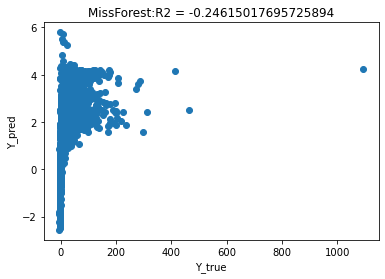

In [57]:
#missForest
Y_pred = missForest.transform(df_train)
Y_true, Y_pred = getY(Y_pred,df_train.values,df_train_true.values)
r2 = r2_score(Y_true, Y_pred)
print(r2)
print(mean_squared_error(Y_true, Y_pred) / np.var(Y_true))

plt.scatter(Y_true, Y_pred)
plt.xlabel('Y_true')
plt.ylabel('Y_pred')
plt.title("MissForest:R2 = " + str(r2))
plt.show()

-0.34048215571156515
1.3404821557115651


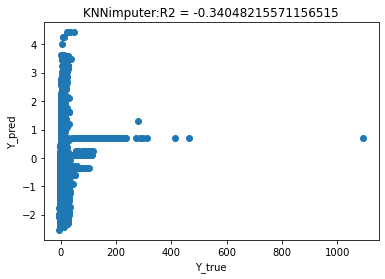

In [58]:
#KNNimputer
df_pred = KNNimputer.transform(df_train)
Y_true, Y_pred = getY(df_pred,df_train.values,df_train_true.values)
r2 = r2_score(Y_true, Y_pred)

print(r2)
print(mean_squared_error(Y_true,Y_pred) / np.var(Y_true))

plt.scatter(Y_true, Y_pred)
plt.xlabel('Y_true')
plt.ylabel('Y_pred')
plt.title("KNNimputer:R2 = " + str(r2))
#plt.ylim(0, 0.02)
#plt.xlim(0, 0.1)
plt.show()

-108.10299981612879
109.10299981612879


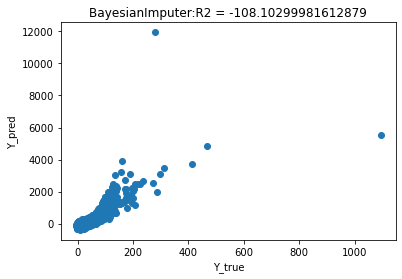

In [59]:
#BayesianImputer)
df_pred = BayesianImputer.transform(df_train)
Y_true, Y_pred = getY(df_pred,df_train.values,df_train_true.values)
r2 = r2_score(Y_true, Y_pred)
print(r2)
print(mean_squared_error(Y_true,Y_pred) / np.var(Y_true))

plt.scatter(Y_true, Y_pred)
plt.xlabel('Y_true')
plt.ylabel('Y_pred')
plt.title("BayesianImputer:R2 = " + str(r2))
#plt.ylim(0, 0.02)
#plt.xlim(0, 0.005)
plt.show()

-0.43707506330499224
1.4370750633049922


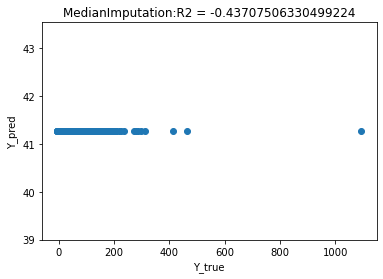

In [60]:
#MedianImputation
df_pred = si_median.transform(df_train)
Y_true, Y_pred = getY(df_pred,df_train.values,df_train_true.values)
r2 = r2_score(Y_true, Y_pred)
print(r2)
print(mean_squared_error(Y_true,Y_pred) / np.var(Y_true))

plt.scatter(Y_true, Y_pred)
plt.xlabel('Y_true')
plt.ylabel('Y_pred')
plt.title("MedianImputation:R2 = " + str(r2))
#plt.ylim(0, 0.02)
#plt.xlim(0, 0.1)
plt.show()

-82.00278764161467
83.00278764161469


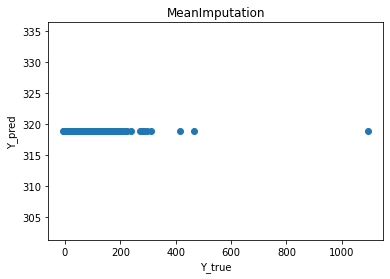

In [61]:
#MeanImputation
df_pred = df_train.fillna(df_train[7].mean())
Y_true, Y_pred = getY(df_pred.values,df_train.values,df_train_true.values)
r2 = r2_score(Y_true, Y_pred)
print(r2)
print(mean_squared_error(Y_true,Y_pred) / np.var(Y_true))

plt.scatter(Y_true, Y_pred)
plt.xlabel('Y_true')
plt.ylabel('Y_pred')
plt.title("MeanImputation:R2 = " + str(r2))
#plt.ylim(0, 0.02)
#plt.xlim(0, 0.1)
plt.title("MeanImputation")
plt.show()


In [62]:
#Y_true, Y_pred = getY(missForest.transform(df_test),df_test,df_test_true)
Y_pred = missForest.transform(df_test)
Y_true, Y_pred = getY(Y_pred,df_test.values,df_test_true.values)
r2 = r2_score(Y_true, Y_pred)
print("R2 of missForest:")
print(r2)

#KNNimputer.score(df_test,df_test_true))
df_pred = KNNimputer.transform(df_test)
Y_true, Y_pred = getY(df_pred,df_test.values,df_test_true.values)
r2 = r2_score(Y_true, Y_pred)
print("R2 of KNNimputer:")
print(r2)

#BayesianImputer.score(df_test,df_test_true))
df_pred = BayesianImputer.transform(df_test)
Y_true, Y_pred = getY(df_pred,df_test.values,df_test_true.values)
r2 = r2_score(Y_true, Y_pred)
print("R2 of BayesianImputer:")
print(r2)

#MedianImputation
df_pred = si_median.transform(df_test)
Y_true, Y_pred = getY(df_pred,df_test.values,df_test_true.values)
r2 = r2_score(Y_true, Y_pred)
print("R2 of MedianImputation:")
print(r2)

#MeanImputation
df_pred = df_test.fillna(df_test[7].mean())
Y_true, Y_pred = getY(df_pred.values,df_test.values,df_test_true.values)
r2 = r2_score(Y_true, Y_pred)
print("R2 of MeanImputation:")
print(r2)


R2 of missForest:
-0.28046581420338446
R2 of KNNimputer:
-0.41162252527417276
R2 of BayesianImputer:
-124.1067610766342
R2 of MedianImputation:
-0.7766135470615305
R2 of MeanImputation:
-173.4645024876317


# Result Summary

If the correlation coefficient (r) is 0 between the predictor variables and the outcome variable in a machine learning algorithm, it means that there is no linear relationship between the predictor variables and the outcome variable. In other words, the predictor variables are not able to explain any of the variation in the outcome variable through a linear relationship.

However, it is important to note that a lack of linear relationship does not necessarily mean that there is no relationship between the predictor variables and the outcome variable. There could be a non-linear relationship, or a relationship that is masked by other variables or interactions. Therefore, it is important to explore other types of models or methods that can capture non-linear or complex relationships, such as polynomial regression, decision trees, or neural networks.

It is also important to note that correlation coefficient is just one measure of association between variables and it only captures linear relationships. There could be other types of relationships between variables that are not captured by correlation coefficient. Therefore, it is always important to carefully analyze and interpret the results of a machine learning algorithm, and to consider other measures of association and model performance.